In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
satellite = getSatelliteImage();

NameError: name 'getSatelliteImage' is not defined

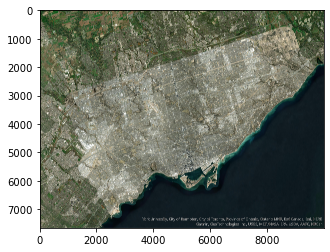

In [ ]:
plt.imshow(satellite)

In [9]:
def getSatelliteImage():
    img = cv2.imread("../res/datasets/images/satellite.png", cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
    return img;

In [10]:
def getTDCSBSchools():
    return pd.read_csv('../res/datasets/schools/TDCSB_Schools.csv', sep = ',')

tdcsbSchools = getTDCSBSchools()

In [11]:
tdcsbSchools

,_id,OBJECTID,TCDSB_CODE,SCH_NAME,ADDRESS_FULL,MUNICIPALITY,POSTAL_CODE,TCDSB_LEVEL,STATUS,geometry
0,1,1,299,Annunciation,65 Avonwick Gt,North York,M3A 2M8,E,Open,"{'type': 'Point', 'coordinates': (-79.32126781..."
1,2,2,290,All Saints,1435 Royal York Rd,Etobicoke,M9P 3A7,E,Open,"{'type': 'Point', 'coordinates': (-79.52716292..."
2,3,3,222,St. Martin Program,55 Salisbury Ave,former Toronto,M4X 1C5,AL,Open,"{'type': 'Point', 'coordinates': (-79.36442584..."
3,4,4,545,Bishop Marrocco-Thomas Merton,1515 Bloor St W,former Toronto,M6P 1A3,S,Open,"{'type': 'Point', 'coordinates': (-79.45180771..."
4,5,5,549,Bishop Allen Academy,721 Royal York Rd,Etobicoke,M8Y 2T3,S,Open,"{'type': 'Point', 'coordinates': (-79.50446467..."
...,...,...,...,...,...,...,...,...,...,...
205,206,206,239,Our Lady of Perpetual Help,1 1/2 Garfield Ave,former Toronto,M4T 1E6,E,Open,"{'type': 'Point', 'coordinates': (-79.38330488..."
206,207,207,291,St Josaphat,110 Tenth St,Etobicoke,M8V 3G1,E,Open,"{'type': 'Point', 'coordinates': (-79.50905953..."
207,208,208,412,North East SAL Program,100 Fundy Bay Blvd,Scarborough,M1W 3G1,AL,Open,"{'type': 'Point', 'coordinates': (-79.31660336..."
208,209,209,848,East Facilities,97 Railside Rd,North York,M3A 1B2,ADM,Open,"{'type': 'Point', 'coordinates': (-79.32406504..."


In [12]:
def getPopDensityImage():
    img = cv2.imread("../res/datasets/images/pop_density.png", cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
    return img;

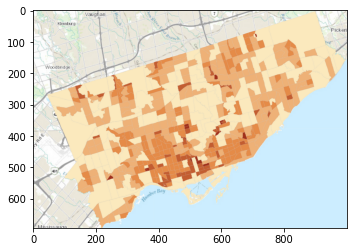

In [13]:
popDensity = getPopDensityImage()
plt.imshow(popDensity)

In [14]:
def getPedestrian():
    return pd.read_csv('../res/datasets/pedestrian/Pedestrian_Network_Data.csv', sep = ',')

In [15]:
pedestrian = getPedestrian()
pedestrian.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87105 entries, 0 to 87104
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   _id                   87105 non-null  int64  
 1   OBJECTID              87105 non-null  int64  
 2   ROAD_TYPE             86315 non-null  object 
 3   SIDEWALK_CODE         87105 non-null  int64  
 4   SIDEWALK_DESCRIPTION  84409 non-null  object 
 5   CROSSWALK             87105 non-null  int64  
 6   CROSSWALK_TYPE        9308 non-null   object 
 7   PX                    7626 non-null   float64
 8   PX_TYPE               7626 non-null   object 
 9   LENGTH                87105 non-null  float64
 10  Shape__Length         87105 non-null  float64
 11  geometry              87105 non-null  object 
dtypes: float64(3), int64(4), object(5)
memory usage: 8.0+ MB


In [16]:
def getZoning():
    # https://open.toronto.ca/dataset/zoning-by-law/
    return pd.read_csv("../res\datasets\images\Toronto_Zoning.csv")

zoning = getZoning()

In [17]:
pedestrian

,_id,GEN_ZONE,ZN_ZONE,ZN_HOLDING,HOLDING_ID,FRONTAGE,ZN_AREA,UNITS,DENSITY,COVERAGE,...,ZN_EXCPTN,EXCPTN_NO,STAND_SET,ZN_STATUS,ZN_STRING,AREA_UNITS,ZBL_CHAPT,ZBL_SECTN,ZBL_EXCPTN,geometry
0,1,NaN,RD,N,NaN,15.0,696.0,NaN,NaN,NaN,...,Y,1096.0,-1.0,2.0,RD (f15.0; a696) (x1096),NaN,10,10.2,900.3.10(1096),"{'type': 'MultiPolygon', 'coordinates': [(((-7..."
1,2,NaN,RD,N,NaN,7.5,225.0,NaN,NaN,NaN,...,Y,412.0,-1.0,2.0,RD (f7.5; a225) (x412),NaN,10,10.2,900.3.10(412),"{'type': 'MultiPolygon', 'coordinates': [(((-7..."
2,3,NaN,RD,N,NaN,15.0,505.0,NaN,NaN,NaN,...,Y,1216.0,-1.0,2.0,RD (f15.0; a505) (x1216),NaN,10,10.2,900.3.10(1216),"{'type': 'MultiPolygon', 'coordinates': [(((-7..."
3,4,4.0,EL,N,NaN,-1.0,-1.0,-1.0,-1.0,NaN,...,N,NaN,-1.0,3.0,EL 2.0,-1.0,60,60.1,None,"{'type': 'MultiPolygon', 'coordinates': [(((-7..."
4,5,NaN,RD,N,NaN,NaN,NaN,NaN,NaN,NaN,...,Y,751.0,-1.0,2.0,RD (x751),NaN,10,10.2,900.3.10(751),"{'type': 'MultiPolygon', 'coordinates': [(((-7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11439,11440,NaN,R,N,NaN,NaN,NaN,NaN,1.0,NaN,...,Y,4.0,-1.0,2.0,R (d1.0) (x4),NaN,10,10.1,900.2.10(4),"{'type': 'MultiPolygon', 'coordinates': [(((-7..."
11440,11441,101.0,RAC,N,NaN,30.0,1375.0,NaN,1.5,NaN,...,N,NaN,-1.0,2.0,RAC (f30.0; a1375; d1.5),NaN,15,15.2,None,"{'type': 'MultiPolygon', 'coordinates': [(((-7..."
11441,11442,101.0,RA,N,NaN,30.0,1375.0,NaN,1.5,NaN,...,N,NaN,-1.0,2.0,RA (f30.0; a1375; d1.5),NaN,15,15.1,None,"{'type': 'MultiPolygon', 'coordinates': [(((-7..."
11442,11443,NaN,RM,N,NaN,130.0,4000.0,84.0,NaN,NaN,...,Y,36.0,-1.0,2.0,RM (f130.0; a4000; u84) (x36),NaN,10,10.8,900.6.10(36),"{'type': 'MultiPolygon', 'coordinates': [(((-7..."


In [18]:
pedestrian.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87105 entries, 0 to 87104
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ROAD_TYPE             86315 non-null  object 
 1   SIDEWALK_DESCRIPTION  84409 non-null  object 
 2   LENGTH                87105 non-null  float64
 3   Shape__Length         87105 non-null  float64
 4   geometry              87105 non-null  object 
dtypes: float64(2), object(3)
memory usage: 3.3+ MB


In [19]:
coordinates = tdcsbSchools.drop(['_id', 'OBJECTID', 'TCDSB_CODE', 'SCH_NAME','ADDRESS_FULL', 'MUNICIPALITY', 'POSTAL_CODE', 'TCDSB_LEVEL', 'STATUS'], 
                  axis = 1)

In [20]:
coordinates = coordinates['geometry'].astype('str')
coordinates = coordinates.apply(lambda x: ast.literal_eval(x))
coordinates = coordinates.apply(pd.Series)

In [21]:
#these are not data frames but instead series 
#be careful when working with them

Latitude = coordinates['coordinates'].apply(lambda x: x[1])
Longitude = coordinates['coordinates'].apply(lambda x: x[0])

In [22]:
def getDistance(origin, stationCor):
    return (geodesic(origin, stationCor).meters/1000)

In [23]:
def score(latStation, longStation, stdDev, latOrigin, longOrigin):
    
    stationCor = (latStation, longStation)
    
    totalScore = 0
    count = 0
    
    for Lat, Long in zip(latOrigin, longOrigin):
            
            origin = (Lat, Long)
            
            r = getDistance(origin, stationCor)
            
            #this can be updated to have a different standard deviation I just chose to have it as
            #0.4 as 0.4km should be where majority of distances fall in
            score = abs((1/(stdDev * math.sqrt(2 * math.pi))) * math.exp(-0.5 * ((r/stdDev)**2)))
            
            totalScore += score
            
    #adjustFactor = 210 * 0.9974
    
    #totalScore = (totalScorePre/adjustFactor)*100
    
    return totalScore

In [29]:
import numpy as np

upperLatBound = 43.806535
bottomLatBound = 43.567208
leftLongBound = -79.597003
rightLongBound = -79.322181

n = 50

scores = pd.DataFrame(columns = ['lat', 'long', 'score'])

for lat in np.arange(bottomLatBound, upperLatBound, (upperLatBound-bottomLatBound)/n):
    
    for long in np.arange(leftLongBound, rightLongBound, (rightLongBound-leftLongBound)/n):
        
        scores = scores.append({'lat' : lat, 'long' : long, 'score' : score(lat, long, 0.6, Latitude, Longitude)}, ignore_index = True)
        
        # print(score(lat, long, 0.4, Latitude, Longitude))
        # plot like this: lat - bottomLatBound,  long - leftLongBound



<AxesSubplot:xlabel='lat', ylabel='long'>

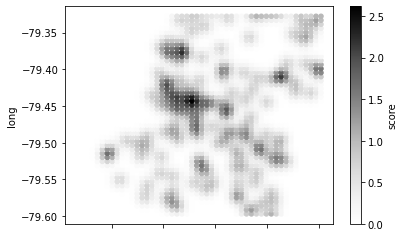

In [30]:
scores.plot.scatter(x="lat", y="long", c="score")

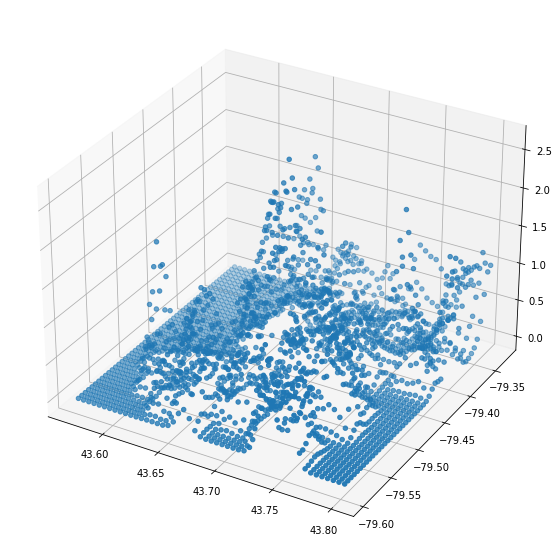

In [32]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.set_figheight(10)
fig.set_figwidth(10)

ax.scatter(scores["lat"], scores["long"], scores["score"])

In [28]:
print(scores)

            lat       long         score
0     43.567208 -79.597003  1.928563e-31
1     43.567208 -79.591507  1.080281e-28
2     43.567208 -79.586010  2.751380e-26
3     43.567208 -79.580514  3.186214e-24
4     43.567208 -79.575017  1.677685e-22
...         ...        ...           ...
2495  43.801748 -79.349663  7.249607e-02
2496  43.801748 -79.344167  2.489758e-01
2497  43.801748 -79.338670  6.006875e-01
2498  43.801748 -79.333174  9.032466e-01
2499  43.801748 -79.327677  8.958265e-01

[2500 rows x 3 columns]
